In [0]:
import torch

from fastai.vision import *
from fastai.basics import *
from fastai.callbacks import *

from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
%matplotlib inline

defaults.device = torch.device('cuda') # makes sure the gpu is used

In [0]:
def get_callbacks(model_name):
  return [
          SaveModelCallback(model_name, every='improvement', monitor='accuracy', name='best'),
          EarlyStoppingCallback(model_name, monitor='accuracy', min_delta=0.01, patience=5)
          ]

In [0]:
model = models.resnet18
epochs_no = 15
lr = 1e-2

## Imagenette-160

In [0]:
import os
if not os.path.isdir('./imagenette2-160.zip'):
  import gdown
  url = 'https://drive.google.com/uc?id=11MOFZF2dVjEu0PbSPmGVWbb2olSZ8eHV'
  output = 'imagenette2-160.zip'
  gdown.download(url, output, quiet=True)
  !unzip "imagenette2-160.zip" -d .
  %rm imagenette2-160.zip

In [0]:
path =  './imagenette2-160'
im_loader = ImageDataBunch.from_folder(path, train='train', valid_pct=0.2, size = 160).normalize(imagenet_stats)

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.45E-03
Min loss divided by 10: 5.75E-03


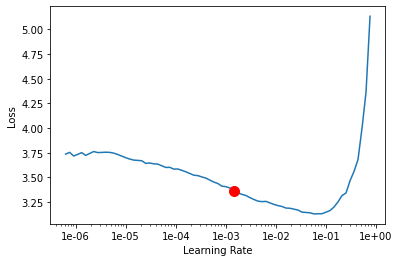

In [0]:
learn = cnn_learner(im_loader, model, metrics=[accuracy], pretrained=False)
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [0]:
learn.fit_one_cycle(epochs_no, lr)

epoch,train_loss,valid_loss,accuracy,time
0,1.968281,1.708785,0.451083,00:23
1,1.564852,5.202297,0.331964,00:23
2,1.644220,1.666151,0.472741,00:23
3,1.458907,1.262482,0.582151,00:23
4,1.257134,1.897746,0.570202,00:23
5,0.970327,1.134116,0.654966,00:23
6,0.890834,1.006698,0.679238,00:23
7,0.768779,1.019268,0.698656,00:23
8,0.657562,0.773895,0.753547,00:23
9,0.497391,0.728259,0.778193,00:23


In [0]:
def plot_graphs(learner, model_name):
  plt = []
  plt.append(['loss.eps',learner.recorder.plot_losses(return_fig=True)])
  plt.append(['acc.eps',learner.recorder.plot_metrics(return_fig=True)])
  plt.append(['lr.eps',learner.recorder.plot_lr(return_fig=True)])
  for plot_name, plot in plt:
    plot.savefig(model_name +'/'+plot_name, format = 'eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


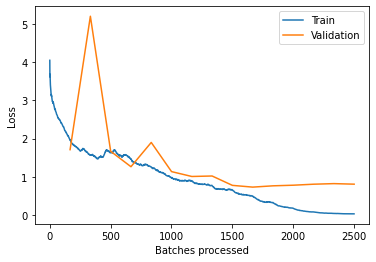

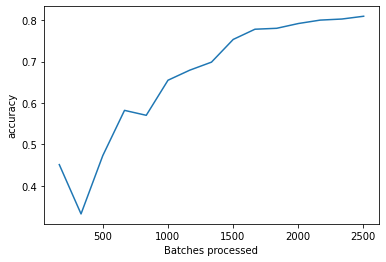

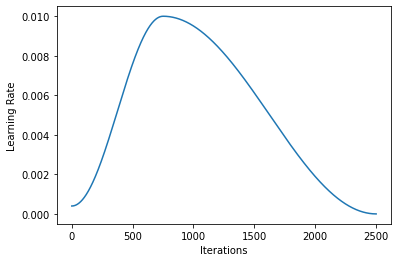

In [0]:
plot_graphs(learn, path)

## Stylized-imagenette-160

In [0]:
if not os.path.isdir('./stylized-imagenette2-160'):
  import gdown
  url = 'https://drive.google.com/uc?id=1af258muaAXdas72oTcS1Wjeu3592Smil'
  output = 'stylized-imagenette2-160.zip'
  gdown.download(url, output, quiet=False)
  !unzip "stylized-imagenette2-160.zip" -d .
  %rm stylized-imagenette2-160.zip

In [0]:
# %rm -r /content/stylized-imagenet-160

In [0]:
np.random.seed(42)
path = './stylized-imagenette2-160'
sin_loader = ImageDataBunch.from_folder(path, train='train', valid_pct=0.2, size=160).normalize(imagenet_stats)

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 9.12E-07
Min loss divided by 10: 5.75E-03


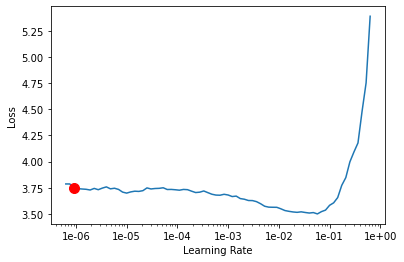

In [0]:
stylized_learn = cnn_learner(sin_loader, model, metrics=accuracy, pretrained=False)
stylized_learn.lr_find()
stylized_learn.recorder.plot(suggestion=True)

In [0]:
stylized_learn.fit_one_cycle(epochs_no, lr)

epoch,train_loss,valid_loss,accuracy,time
0,2.649034,5.609441,0.168783,00:23
1,2.535085,7.153675,0.146378,00:23
2,2.558449,2.245657,0.228902,00:23
3,2.262116,2.001658,0.281180,00:23
4,1.972053,2.013143,0.299477,00:23
5,1.873373,2.061917,0.366318,00:23
6,1.777739,1.708728,0.412995,00:23
7,1.641721,1.694361,0.417476,00:23
8,1.447274,1.532621,0.482076,00:23
9,1.260920,1.423438,0.533981,00:23


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


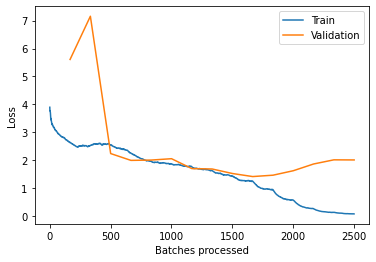

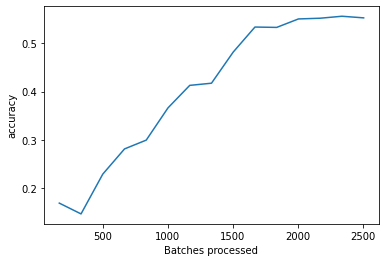

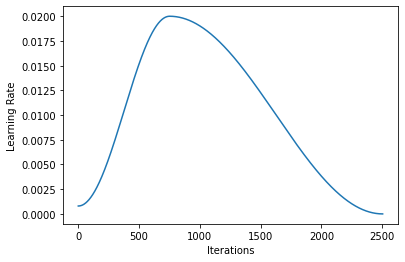

In [0]:
plot_graphs(stylized_learn,path)

# Test set results

In [0]:
from copy import deepcopy

path =  './imagenette2-160'
in_loader_test = ImageDataBunch.from_folder(path, train='train', valid='val',size=160).normalize(imagenet_stats)
test_set_in = deepcopy(in_loader_test.valid_dl)

In [0]:
path = './stylized-imagenette2-160'
sin_loader_test = ImageDataBunch.from_folder(path, train='train', valid='val',size=160).normalize(imagenet_stats)
test_set_sin = deepcopy(sin_loader_test.valid_dl)

In [0]:
def test(learner, target_dataset):
  learner.data.valid_dl = target_dataset
  interp_sin = ClassificationInterpretation.from_learner(learner)
  plot = interp_sin.plot_confusion_matrix(return_fig = True)
  plot.savefig('confusion_matrix.eps', format = 'eps')
  print(learner.validate(target_dataset, metrics = [accuracy]))

## SIN --> SIN

[0.4309209, tensor(0.9083)]


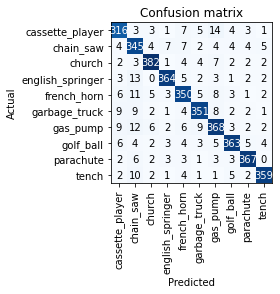

In [0]:
test(stylized_learn, test_set_sin)

## SIN --> IN

[1.7764374, tensor(0.6242)]


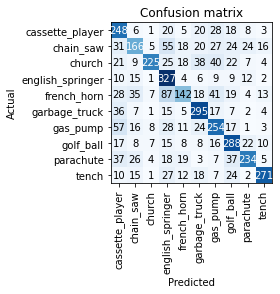

In [0]:
test(stylized_learn, test_set_in)

## IN --> IN

[0.15570219, tensor(0.9628)]


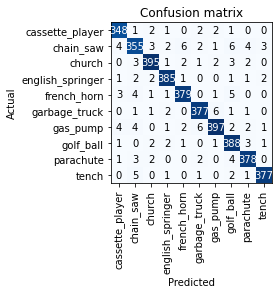

In [0]:
test(learn, test_set_in)

## IN --> SIN


[3.45685, tensor(0.3134)]


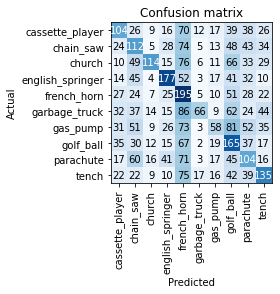

In [0]:
test(learn, test_set_sin)

## SIN + IN --> IN

In [0]:
if not os.path.isdir('./sin-in'):
  import gdown
  url = 'https://drive.google.com/uc?id=1yCDaEqH_cCTWULSJ_HK4-pm32dWh6w4p'
  output = 'sin-in.zip'
  gdown.download(url, output, quiet=False)
  !unzip "sin-in.zip" -d .
  %rm sin-in.zip

In [0]:
np.random.seed(42)
path = './sin-in'

sinin_loader = ImageDataBunch.from_folder(path, train='train', valid_pct=0.2,size=160).normalize(imagenet_stats)

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.31E-04
Min loss divided by 10: 3.98E-03


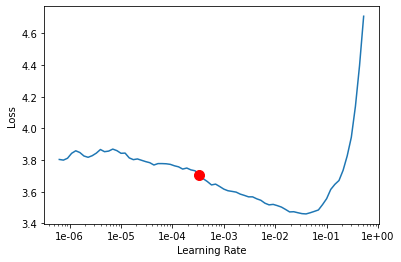

In [0]:
sinin_learn = cnn_learner(sinin_loader, model, metrics=accuracy, pretrained=False)
sinin_learn.lr_find()
sinin_learn.recorder.plot(suggestion=True)

In [0]:
sinin_learn.fit_one_cycle(epochs_no, lr)

epoch,train_loss,valid_loss,accuracy,time
0,2.240858,2.125547,0.325350,00:45
1,2.044119,2.443912,0.377834,00:44
2,1.686326,1.897236,0.479236,00:44
3,1.355040,1.218238,0.608662,00:45
4,1.165247,0.980859,0.682293,00:44
5,0.970899,0.662566,0.791083,00:45
6,0.779936,0.549673,0.817070,00:44
7,0.568017,0.293110,0.916688,00:44
8,0.313210,0.189306,0.946497,00:44
9,0.170200,0.167712,0.955924,00:44


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


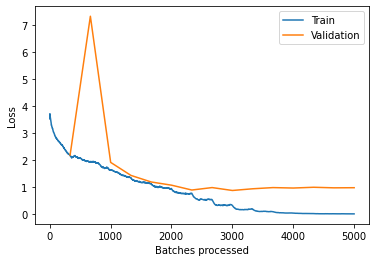

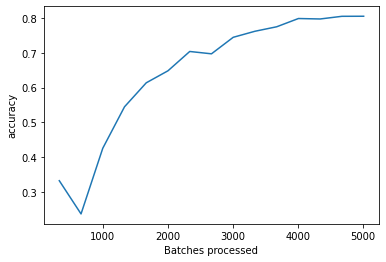

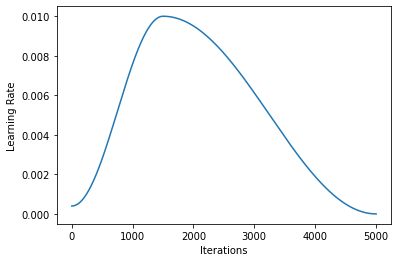

In [0]:
plot_graphs(sinin_learn, path)

[0.1457646, tensor(0.9732)]


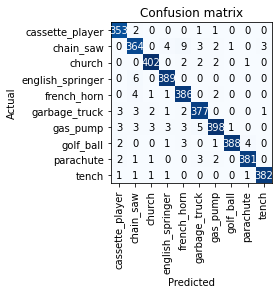

In [0]:
test(sinin_learn, test_set_in)

## SIN + IN + finetune(IN)-> IN

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 9.12E-07
Min loss divided by 10: 1.10E-07


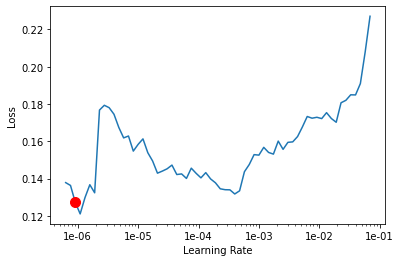

In [0]:
train_set_in = deepcopy(in_loader_test.train_dl)

sinin_finetune_learn = deepcopy(sinin_learn)
sinin_finetune_learn.data.train_dl = train_set_in # use only IN dataset for finetune
sinin_finetune_learn.unfreeze()
sinin_finetune_learn.lr_find()
sinin_finetune_learn.recorder.plot(suggestion=True)
sinin_finetune_learn.freeze() 

In [0]:
sinin_finetune_learn.fit_one_cycle(epochs_no, 1e-4, callbacks= get_callbacks(sinin_finetune_learn))

epoch,train_loss,valid_loss,accuracy,time
0,0.176601,0.135774,0.974268,00:21
1,0.170269,0.138833,0.972994,00:21
2,0.157416,0.138950,0.973503,00:21
3,0.155417,0.132036,0.973758,00:21
4,0.148514,0.135479,0.974268,00:21
5,0.162777,0.130927,0.974013,00:20


Better model found at epoch 0 with accuracy value: 0.9742675423622131.
Epoch 6: early stopping


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


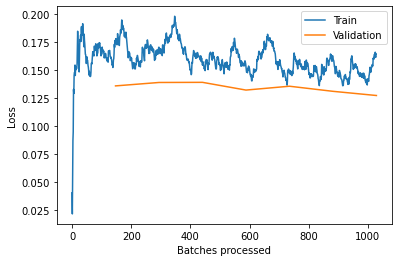

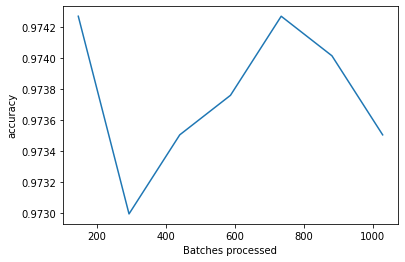

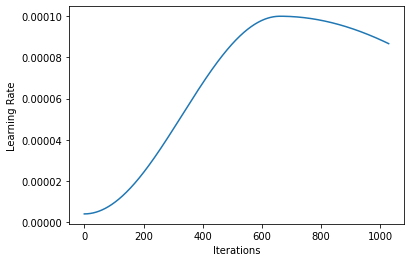

In [0]:
# !mkdir './finetune'
plot_graphs(sinin_finetune_learn, './finetune')

[0.13577437, tensor(0.9743)]


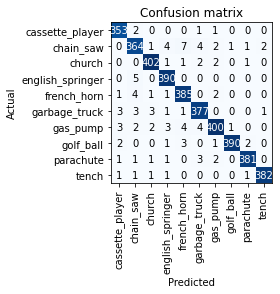

In [0]:
test(sinin_finetune_learn, test_set_in)

### custom transform

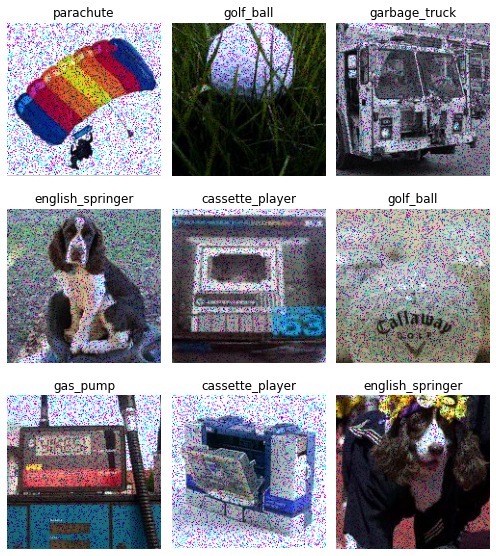

In [0]:
import cv2
import warnings
warnings.filterwarnings('ignore')

def _noise(x, amount):
  x = image2np(x*255).astype('uint8')
  row,col,ch = x.shape
  s_vs_p = 0.5
  # Salt mode
  num_salt = np.ceil(amount * x.size * s_vs_p)
  coords = [np.random.randint(0, i - 1, int(num_salt))
          for i in x.shape]
  x[coords] = 1

  # Pepper mode
  num_pepper = np.ceil(amount* x.size * (1. - s_vs_p))
  coords = [np.random.randint(0, i - 1, int(num_pepper))
          for i in x.shape]
  x[coords] = 0

  x = pil2tensor(x,np.float32)
  x.div_(255)

  return x

noise = TfmPixel(_noise)
data = ImageDataBunch.from_folder(
        path,
        train='train', valid='val',
        ds_tfms=[
                  [noise(amount=0.1)], [noise(amount=0.1)]
                  ],
        size=160).normalize(imagenet_stats)
data.show_batch(rows=3, figsize=(7, 8))

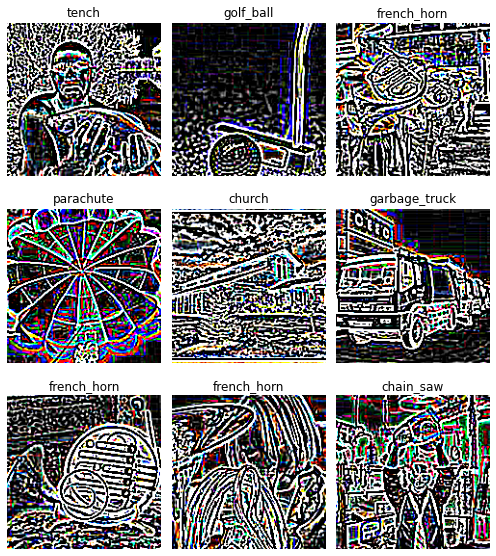

In [0]:
def _high_pass(x, ksize):
  x = image2np(x*255).astype('uint8')

  x = cv2.Laplacian(x, 0, ksize=ksize)
  x = pil2tensor(x,np.float32)
  x.div_(255)

  return x

high_pass = TfmPixel(_high_pass)
ksize = 5
data = ImageDataBunch.from_folder(
        path,
        train='train', valid='val',
        ds_tfms=[
                  [high_pass( ksize=ksize)], [high_pass(ksize=ksize)]
                  ],
        size=160).normalize(imagenet_stats)
data.show_batch(rows=3, figsize=(7, 8))

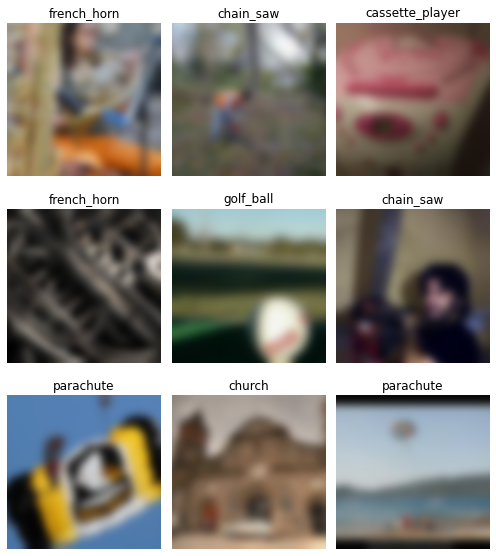

In [0]:
def _low_pass(x, size):
  x = image2np(x*255).astype('uint8')

  x = cv2.GaussianBlur(x,(size,size), 0)
  x = pil2tensor(x,np.float32)
  x.div_(255)

  return x

low_pass = TfmPixel(_low_pass)
size = 29
data = ImageDataBunch.from_folder(
        path,
        train='train', valid='val',
        ds_tfms=[
                  [low_pass(size=size)], [low_pass(size=size)]
                  ],
        size=160).normalize(imagenet_stats)
data.show_batch(rows=3, figsize=(7, 8))

In [0]:
path = './imagenette2-160'
uniform_x = [0.004, 0.01, 0.05, 0.1, 0.5]

noise_ins = [
             (
              amount,
              ImageDataBunch.from_folder(
                path,
                train='train', valid='val',
                ds_tfms=[
                         [noise(amount=amount)], [noise(amount=amount)]
                         ],
                size=160).normalize(imagenet_stats))
              for amount in uniform_x]



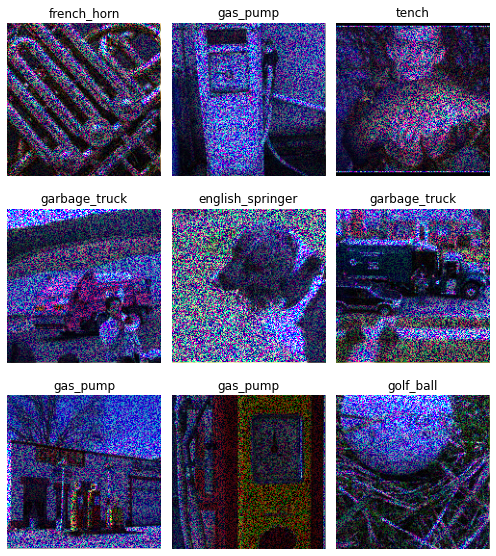

In [0]:
noise_ins[-1][1].show_batch(rows=3, figsize=(7, 8))

In [0]:
import matplotlib.pyplot as plt


noise

In [0]:
in_results = []
for magnitude, data in noise_ins:
  metrics = learn.validate(data.valid_dl, metrics = [accuracy, top_k_accuracy])
  in_results.append(metrics[1])
  print('in', magnitude, metrics)

in 0.004 [0.3504651, tensor(0.8904), tensor(0.9918)]


in 0.01 [0.38796252, tensor(0.8772), tensor(0.9906)]


in 0.05 [0.8235424, tensor(0.7373), tensor(0.9817)]


in 0.1 [1.4446952, tensor(0.6066), tensor(0.9452)]


in 0.5 [3.5475833, tensor(0.2948), tensor(0.6874)]


In [0]:
sin_results = []
for magnitude, data in noise_ins:
  metrics = stylized_learn.validate(data.valid_dl, metrics = [accuracy, top_k_accuracy])
  sin_results.append(metrics[1])

  print('sin', magnitude, metrics)

sin 0.004 [1.4763333, tensor(0.5893), tensor(0.9284)]


sin 0.01 [1.4783213, tensor(0.5868), tensor(0.9292)]


sin 0.05 [1.4830538, tensor(0.5773), tensor(0.9279)]


sin 0.1 [1.5224193, tensor(0.5564), tensor(0.9157)]


sin 0.5 [2.361484, tensor(0.3332), tensor(0.7839)]


In [0]:
sinin_results = []
for magnitude, data in noise_ins:
  metrics = sinin_learn.validate(data.valid_dl, metrics = [accuracy, top_k_accuracy])
  sinin_results.append(metrics[1])

  print('sin+in', magnitude, metrics)

sin+in 0.004 [0.4232786, tensor(0.8701), tensor(0.9885)]


sin+in 0.01 [0.42454094, tensor(0.8721), tensor(0.9890)]


sin+in 0.05 [0.48356804, tensor(0.8479), tensor(0.9806)]


sin+in 0.1 [0.585763, tensor(0.8138), tensor(0.9712)]


sin+in 0.5 [1.9217385, tensor(0.4668), tensor(0.8346)]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


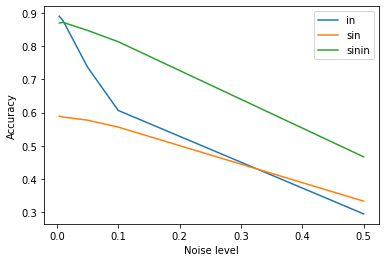

In [0]:
plt.xlabel('Noise level')
plt.ylabel('Accuracy')
plt.plot(uniform_x, in_results, label='in')
plt.plot(uniform_x, sin_results, label = 'sin')
plt.plot(uniform_x, sinin_results, label='sinin')
plt.legend()
plt.savefig('uniform.eps', format = 'eps')

high pass

In [0]:
high_pass_x = [1, 3, 5, 7, 9]
high_ins = [
             (
              ksize,
              ImageDataBunch.from_folder(
                path,
                train='train', valid='val',
                ds_tfms=[
                          [high_pass( ksize=ksize)], [high_pass(ksize=ksize)]
                         ],
                size=160).normalize(imagenet_stats))
              for ksize in high_pass_x]


In [0]:
in_results = []
for magnitude, data in high_ins:
  metrics = learn.validate(data.valid_dl, metrics = [accuracy, top_k_accuracy])
  in_results.append(metrics[1])
  print('in', magnitude, metrics)

in 1 [3.674961, tensor(0.1941), tensor(0.6517)]


in 3 [4.451701, tensor(0.2031), tensor(0.5590)]


in 5 [5.2485175, tensor(0.1569), tensor(0.5873)]


in 7 [5.0480413, tensor(0.1439), tensor(0.5845)]


in 9 [4.8208528, tensor(0.1358), tensor(0.5890)]


In [0]:
sin_results = []
for magnitude, data in high_ins:
  metrics = stylized_learn.validate(data.valid_dl, metrics = [accuracy, top_k_accuracy])
  sin_results.append(metrics[1])

  print('sin', magnitude, metrics)

sin 1 [3.3048363, tensor(0.1093), tensor(0.5210)]


sin 3 [3.4107714, tensor(0.2082), tensor(0.7027)]


sin 5 [7.207053, tensor(0.1307), tensor(0.5878)]


sin 7 [5.8872995, tensor(0.1225), tensor(0.5666)]


sin 9 [5.62245, tensor(0.1236), tensor(0.5567)]


In [0]:
sinin_results = []
for magnitude, data in high_ins:
  metrics = sinin_learn.validate(data.valid_dl, metrics = [accuracy, top_k_accuracy])
  sinin_results.append(metrics[1])

  print('sin+in', magnitude, metrics)

sin+in 1 [3.2414033, tensor(0.2173), tensor(0.6344)]


sin+in 3 [2.6994014, tensor(0.3664), tensor(0.6879)]


sin+in 5 [4.3284144, tensor(0.2803), tensor(0.6316)]


sin+in 7 [4.012702, tensor(0.2385), tensor(0.6275)]


sin+in 9 [3.898596, tensor(0.2158), tensor(0.6229)]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


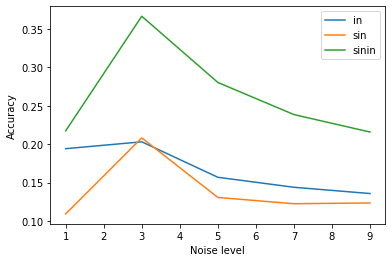

In [0]:
plt.xlabel('Noise level')
plt.ylabel('Accuracy')

plt.plot(high_pass_x, in_results, label='in')
plt.plot(high_pass_x, sin_results, label = 'sin')
plt.plot(high_pass_x, sinin_results, label='sinin')
plt.legend()
plt.savefig('high_pass.eps', format = 'eps')

Low pass

In [0]:
low_pass_x = [1, 7, 21, 31, 41]
low_ins = [
             (
              size,
              ImageDataBunch.from_folder(
                path,
                train='train', valid='val',
                ds_tfms=[
                        [low_pass(size=size)], [low_pass(size=size)]
                         ],
                size=160).normalize(imagenet_stats))
              for size in low_pass_x]

In [0]:
in_results = []
for magnitude, data in low_ins:
  metrics = learn.validate(data.valid_dl, metrics = [accuracy, top_k_accuracy])
  in_results.append(metrics[1])
  print('in', magnitude, metrics)

in 1 [0.32744125, tensor(0.8971), tensor(0.9929)]


in 7 [1.3621514, tensor(0.6583), tensor(0.9564)]


in 21 [3.115263, tensor(0.3228), tensor(0.7776)]


in 31 [4.599311, tensor(0.2089), tensor(0.7287)]


in 41 [5.702437, tensor(0.1697), tensor(0.7004)]


In [0]:
sin_results = []
for magnitude, data in low_ins:
  metrics = stylized_learn.validate(data.valid_dl, metrics = [accuracy, top_k_accuracy])
  sin_results.append(metrics[1])

  print('sin', magnitude, metrics)

sin 1 [1.4754957, tensor(0.5896), tensor(0.9289)]


sin 7 [1.7218375, tensor(0.5126), tensor(0.9065)]


sin 21 [2.641615, tensor(0.2746), tensor(0.7852)]


sin 31 [3.674541, tensor(0.1501), tensor(0.6532)]


sin 41 [4.259989, tensor(0.1192), tensor(0.5625)]


In [0]:
sinin_results = []
for magnitude, data in low_ins:
  metrics = sinin_learn.validate(data.valid_dl, metrics = [accuracy, top_k_accuracy])
  sinin_results.append(metrics[1])

  print('sin+in', magnitude, metrics)

sin+in 1 [0.4208584, tensor(0.8713), tensor(0.9893)]


sin+in 7 [0.723891, tensor(0.7738), tensor(0.9654)]


sin+in 21 [1.2032974, tensor(0.6051), tensor(0.9172)]


sin+in 31 [1.6875663, tensor(0.4591), tensor(0.8652)]


sin+in 41 [2.337218, tensor(0.3042), tensor(0.7768)]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


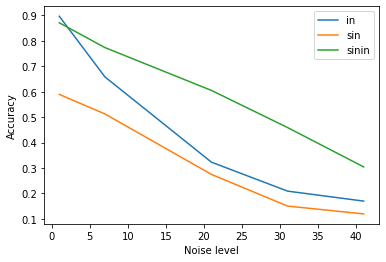

In [0]:
plt.xlabel('Noise level')
plt.ylabel('Accuracy')

plt.plot(low_pass_x, in_results, label='in')
plt.plot(low_pass_x, sin_results, label = 'sin')
plt.plot(low_pass_x, sinin_results, label='sinin')
plt.legend()

plt.savefig('low_pass.eps', format = 'eps')